# Replication of Todd W. Schneider's Study of Citibike Data

Replication is a useful thing to do, mostly for the sake of learning the dataset better. Here's the [original article.](http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/)

I use an entirely different technology stack (Python + Dask + PySpark), as compared to Todd's PostgreSQL, PostGIS and R stack. So no code is directly shared, and my analysis is independent.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import dask.dataframe as dd
import dask.array as da
import dask.distributed
import geopandas as gpd
import pandas as pd
import numpy as np
import sklearn
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm as symlog
from matplotlib import rcParams
import seaborn as sns
import palettable
sns.set_style('white')

client = dask.distributed.Client('localhost:8786')

In [2]:
rcParams['font.family']  = 'sans-serif'

In [3]:
rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 12
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'


import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

In [4]:
df1 = spark.read.parquet('/data/citibike_spark.parquet')
df1.registerTempTable('bike')

In [5]:
df2 = dd.read_parquet('/data/citibike.parquet')
# df2 = dd.read_parquet('/data/citibike.parquet', columns=['start_station_id', 'trip_duration'])

# Option 1: Consider the number of trips over all time

In [6]:
station_counts = spark.sql("SELECT start_station_id, count(start_station_id) as N_depart FROM bike GROUP BY "
          "start_station_id ORDER BY N_depart DESC").toPandas().set_index('start_station_id', drop=True)
station_counts_2 = spark.sql("SELECT end_station_id, count(end_station_id) as N_arrive FROM bike GROUP BY "
          "end_station_id ORDER BY N_arrive DESC").toPandas().set_index('end_station_id', drop=True)

station_counts = station_counts.merge(station_counts_2, left_index=True, right_index=True, how='inner')
del station_counts_2

In [7]:
station_locations = spark.sql("SELECT distinct start_station_id, start_station_latitude, start_station_longitude "
          "FROM bike ORDER BY start_station_id").toPandas().groupby('start_station_id').last()
stations = station_locations.merge(station_counts, left_index=True, right_index=True)

N_THRESHOLD = 500

stations = stations[stations.N_depart + stations.N_arrive >= N_THRESHOLD]

stations = gpd.GeoDataFrame(stations,
                                     geometry=[Point(x, y) for x,y in 
                                              zip(stations.start_station_longitude, 
                                                  stations.start_station_latitude)], 
                                     crs={'init' :'epsg:4326'})
stations['SQRT_N_depart'] = (stations.N_depart ** 0.5) / (N_THRESHOLD**0.5)
stations['SQRT_N_arrive'] = (stations.N_arrive ** 0.5) / (N_THRESHOLD**0.5)
stations.head()

start_station_latitude  start_station_longitude  N_depart  N_arrive  \
519               40.752416               -73.978370    386862    347097   
497               40.737050               -73.990093    307269    320748   
435               40.741740               -73.994156    291642    291753   
426               40.717548               -74.013221    273384    278529   
293               40.730287               -73.990765    266396    267498   

                             geometry  SQRT_N_depart  SQRT_N_arrive  
519       POINT (-73.97837 40.752416)      27.815895      26.347562  
497  POINT (-73.99009296 40.73704984)      24.789877      25.327771  
435  POINT (-73.99415556 40.74173969)      24.151273      24.155869  
426  POINT (-74.01322069 40.71754834)      23.383071      23.602076  
293   POINT (-73.9907647 40.73028666)      23.082288      23.129981

In [8]:
stations.tail()

start_station_latitude  start_station_longitude  N_depart  N_arrive  \
3393               40.679433               -74.007850       524       565   
3394               40.676999               -74.006471       431       530   
3342               40.677775               -74.009461       388       511   
3326               40.674340               -74.001947       413       409   
3130               40.753260               -73.943358       278       235   

                                    geometry  SQRT_N_depart  SQRT_N_arrive  
3393  POINT (-74.00785041 40.67943270000001)       1.023719       1.063015  
3394         POINT (-74.00647134 40.6769993)       0.928440       1.029563  
3342   POINT (-74.0094613 40.67777479999999)       0.880909       1.010940  
3326           POINT (-74.00194698 40.67434)       0.908845       0.904434  
3130  POINT (-73.94335787999999 40.75325964)       0.745654       0.685565

In [9]:
tz = gpd.read_file('../shapefiles/taxi_zones.shp')
tz.geometry = tz.geometry.rotate(28, origin=(990000., 205000.))

In [10]:
stations = stations.to_crs(tz.crs)
stations.geometry = stations.geometry.rotate(28, origin=(990000., 205000.))

In [11]:
stations = stations.sort_values('N_depart')

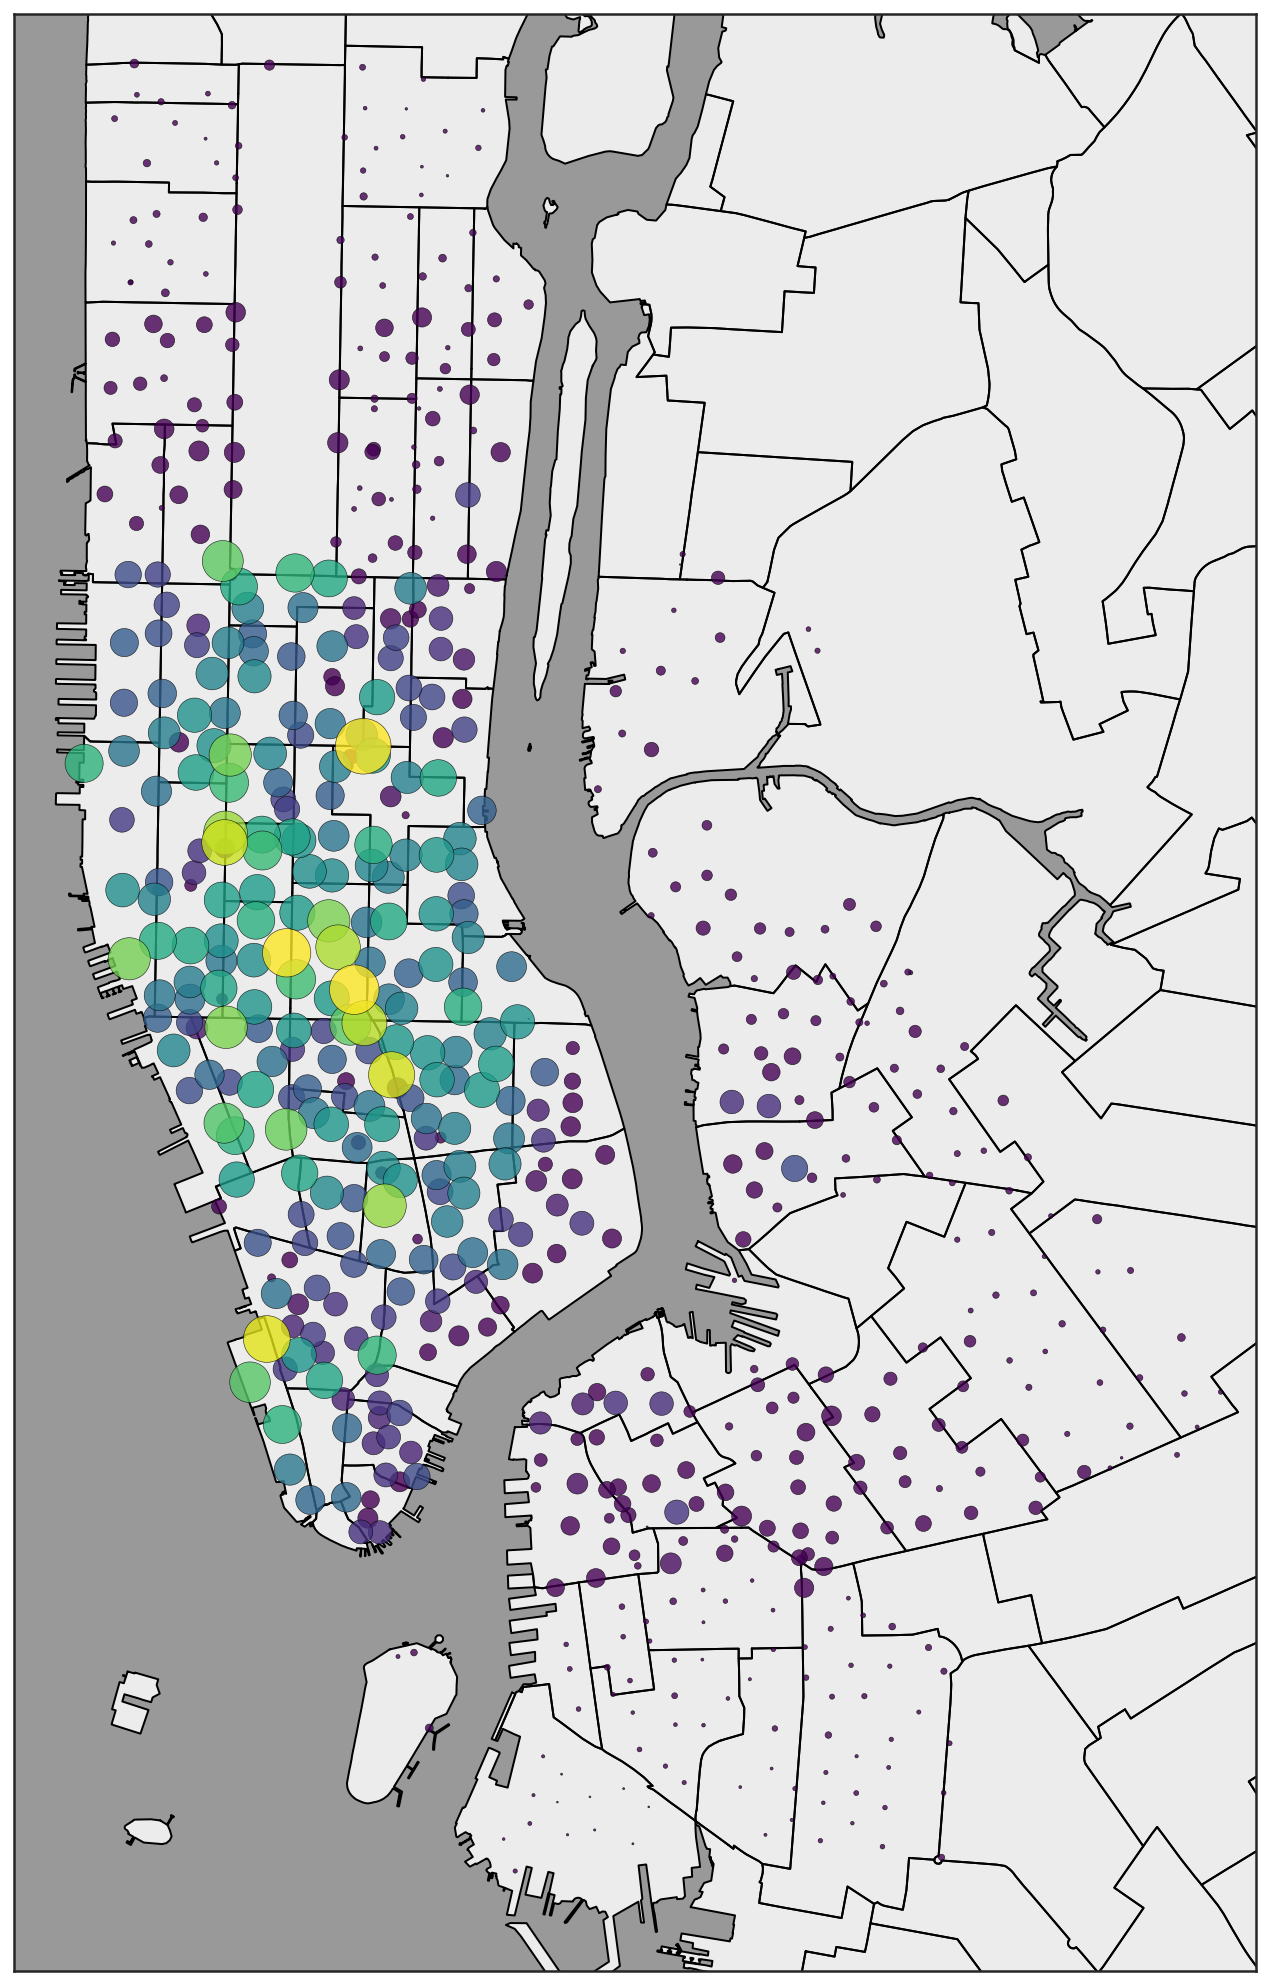

In [12]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)
plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)

ax = plt.gca()
ax.set_facecolor("#999999")

xlocs, ylocs = np.array([np.array(xy) for xy in stations.geometry.values]).T

z = ax.scatter(xlocs, ylocs, marker='o', c=stations.SQRT_N_depart, 
                      s=stations.N_depart/N_THRESHOLD, cmap=plt.cm.viridis,
                      vmin=10, vmax=24, edgecolors='k', alpha=0.8, zorder=10000)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Above is the number of departures (trips that begin) for each bike station over the entire dataset. The most trips seem to start and end in midtown and downtown, with far fewer trips starting and ending in uptown or Brooklyn.

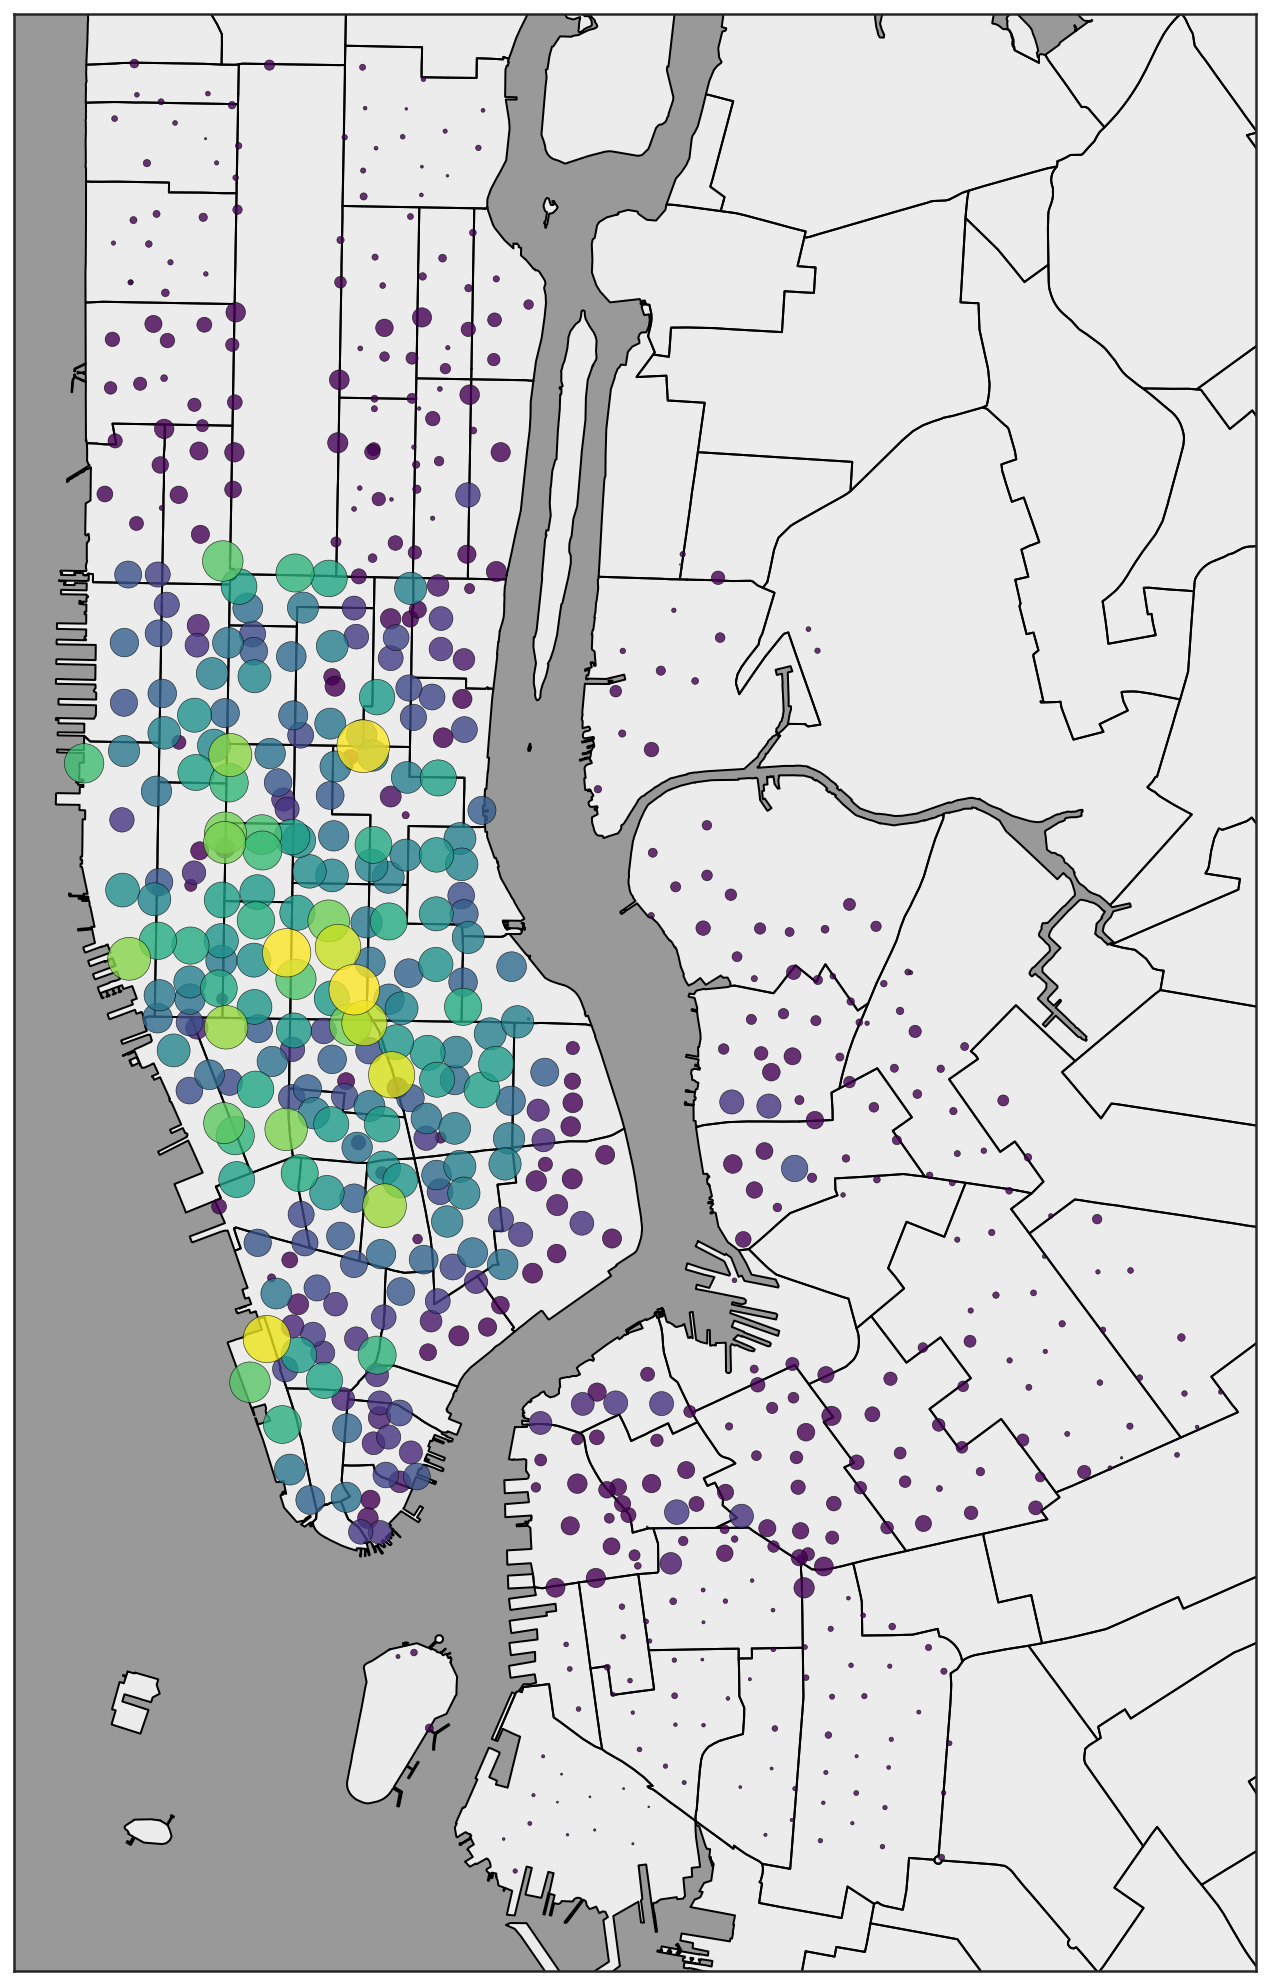

In [13]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)

plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)

ax = plt.gca()
ax.set_facecolor("#999999")

xlocs, ylocs = np.array([np.array(xy) for xy in stations.geometry.values]).T

z = plt.gca().scatter(xlocs, ylocs, marker='o', c=stations.SQRT_N_arrive, 
                      s=stations.N_arrive/N_THRESHOLD, cmap=plt.cm.viridis,
                      vmin=10, vmax=24, edgecolors='k', alpha=0.8, zorder=10000)

plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

Above is the number of arrivals (trips that end) for each bike station over the entire dataset. This has a (mostly) similar pattern, but there are some differences as well. Let's subtract to get a clearer picture. 

In [14]:
stations['N_deficit'] = stations.N_depart - stations.N_arrive

In [15]:
lowcolor,highcolor = palettable.colorbrewer.diverging.RdBu_5.hex_colors[0::4]

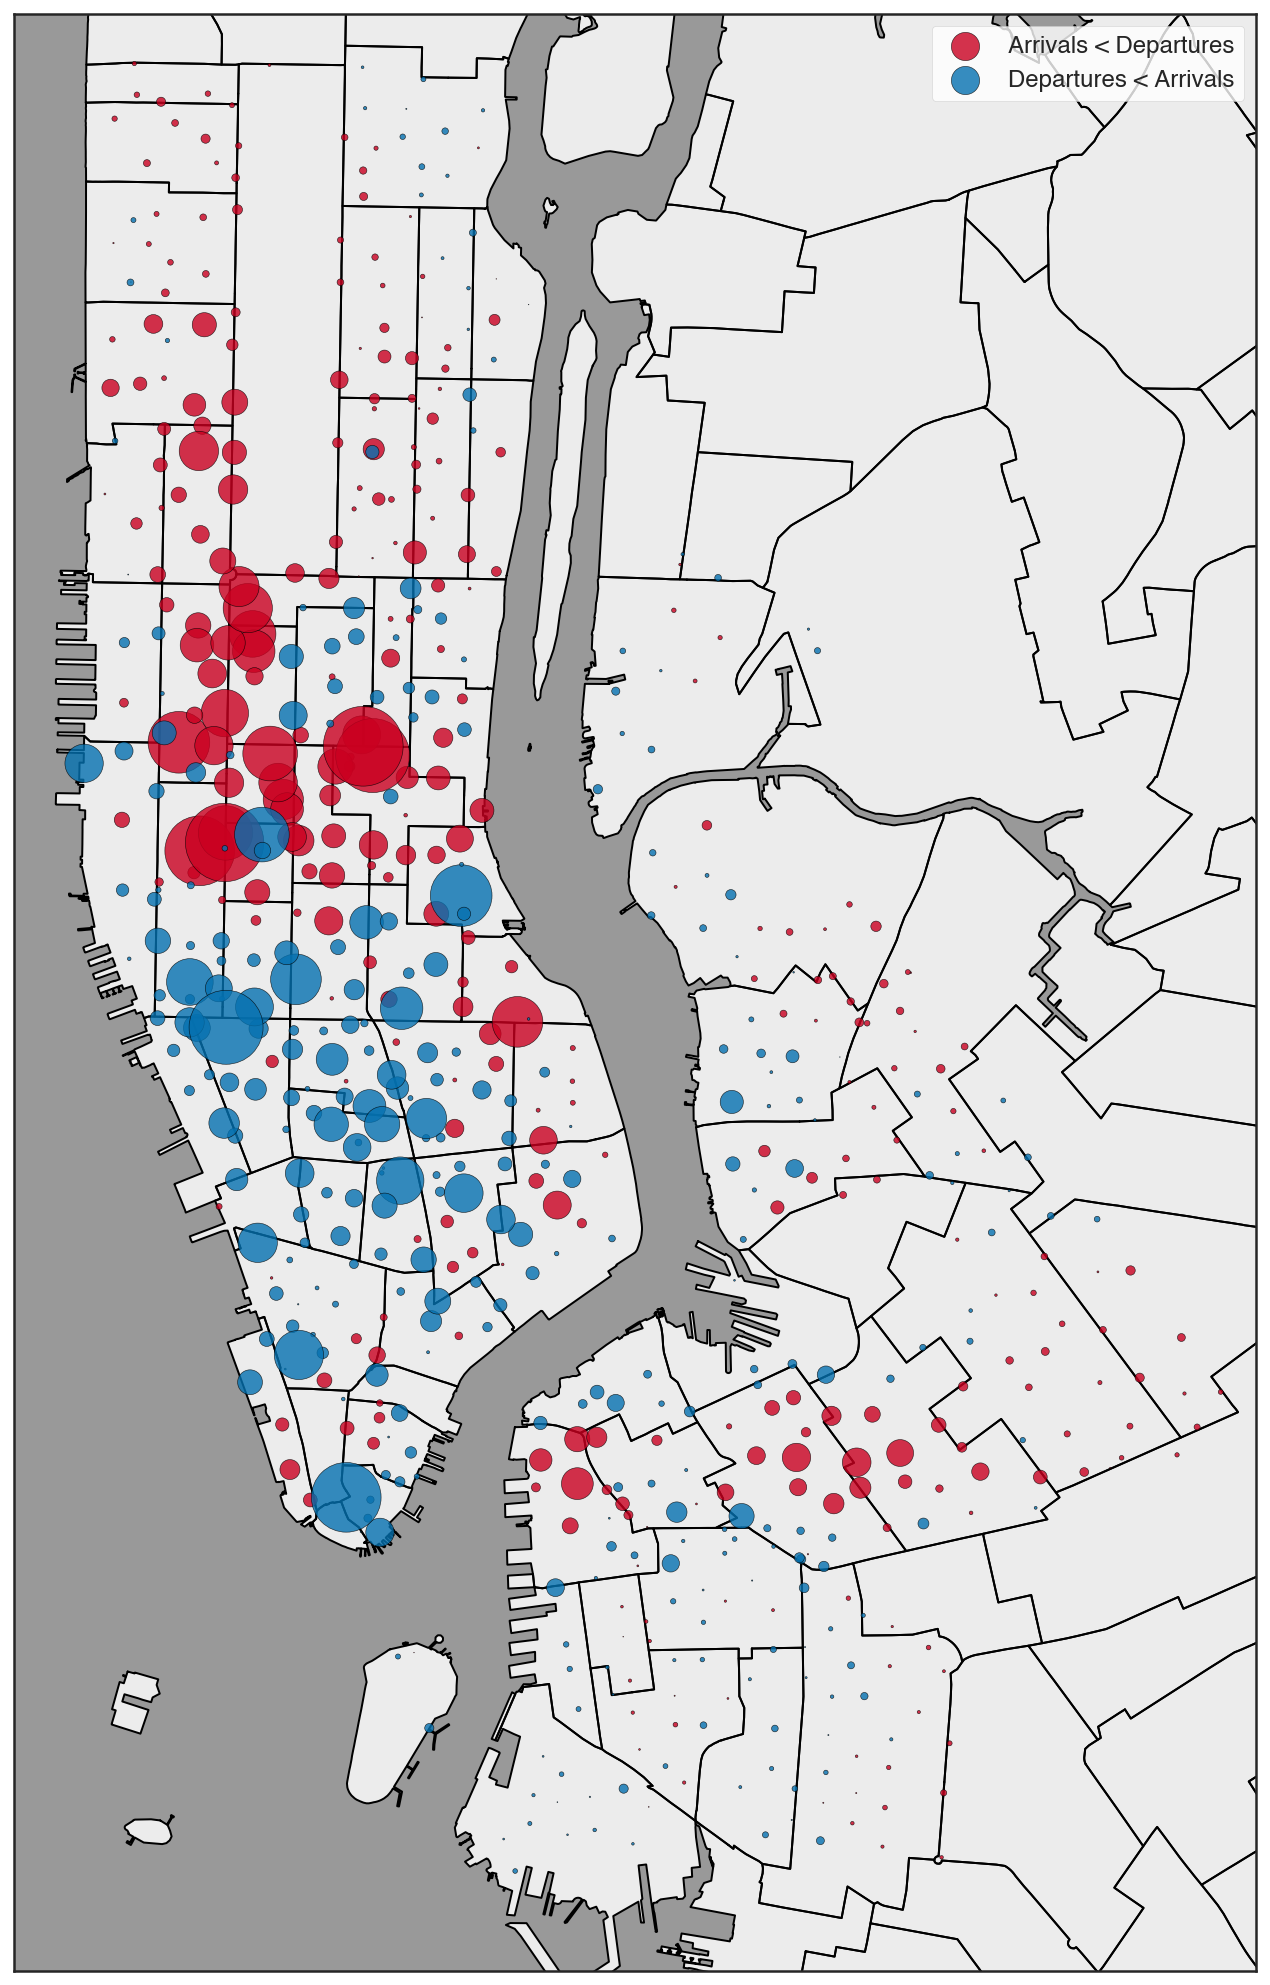

In [16]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)
plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)



ax = plt.gca()
ax.set_facecolor("#999999")

stations1 = stations[stations.N_deficit > 0]
stations2 = stations[stations.N_deficit <= 0]

xlocs, ylocs = np.array([np.array(xy) for xy in stations1.geometry.values]).T
z = plt.gca().scatter(xlocs, ylocs, marker='o', #c=stations1.N_deficit, 
                      s=stations1.N_deficit/(N_THRESHOLD/20), c=lowcolor,
                      vmin=0, vmax=4000, label='Arrivals < Departures',
                      edgecolors='k', alpha=0.8, zorder=10000)

xlocs, ylocs = np.array([np.array(xy) for xy in stations2.geometry.values]).T
z = plt.gca().scatter(xlocs, ylocs, marker='o', #c=stations1.N_deficit, 
                      s=stations1.N_deficit.abs()/(N_THRESHOLD/20), c=highcolor,
                      vmin=0, vmax=4000, label='Departures < Arrivals',
                      edgecolors='k', alpha=0.8, zorder=10000)

plt.legend(markerscale=.5, loc='upper right', frameon=True, fontsize=12)


plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

The above plot shows regions where more bikes arrive than depart (blue). This would correspond to full bike racks if the citibike system did not rebalance the bikes. Similarly, regions that are red indicate more bikes depart than arrive, which would lead to empty bike racks without rebalancing. Within Manhattan, broadly speaking, more people use citibike to go downtown rather than uptown, and the citibike system is surely transporting some bikes uptown. 

However this is not the full story. The bikeshare system opened many new stations in August 2015. Let's divide the dataset into before August 2015 and after August 2015.

# Option 2: After August 2015

In [17]:
station_counts = spark.sql("SELECT start_station_id, count(start_station_id) as N_depart FROM bike "
                           "WHERE start_time > '2015-09-01' "
                           "GROUP BY start_station_id ORDER BY N_depart DESC") \
                     .toPandas().set_index('start_station_id', drop=True)
station_counts_2 = spark.sql("SELECT end_station_id, count(end_station_id) as N_arrive FROM bike "
                           "WHERE start_time > '2015-09-01' "
                           "GROUP BY end_station_id ORDER BY N_arrive DESC") \
        .toPandas().set_index('end_station_id', drop=True)

station_counts = station_counts.merge(station_counts_2, left_index=True, right_index=True, how='inner')
del station_counts_2

In [18]:
station_locations = spark.sql("SELECT distinct start_station_id, start_station_latitude, start_station_longitude "
          "FROM bike ORDER BY start_station_id").toPandas().groupby('start_station_id').last()
stations = station_locations.merge(station_counts, left_index=True, right_index=True)

N_THRESHOLD = 500

stations = stations[stations.N_depart + stations.N_arrive >= N_THRESHOLD]

stations = gpd.GeoDataFrame(stations,
                                     geometry=[Point(x, y) for x,y in 
                                              zip(stations.start_station_longitude, 
                                                  stations.start_station_latitude)], 
                                     crs={'init' :'epsg:4326'})
stations['SQRT_N_depart'] = (stations.N_depart ** 0.5) / (N_THRESHOLD**0.5)
stations['SQRT_N_arrive'] = (stations.N_arrive ** 0.5) / (N_THRESHOLD**0.5)
stations = stations.to_crs(tz.crs)
stations.geometry = stations.geometry.rotate(28, origin=(990000., 205000.))

In [19]:
stations['N_deficit'] = stations.N_depart - stations.N_arrive

In [20]:
stations.N_deficit.describe()

count      641.000000
mean         1.934477
std       2410.754564
min     -11878.000000
25%       -442.000000
50%         20.000000
75%        437.000000
max      30369.000000
Name: N_deficit, dtype: float64

In [21]:
stations.SQRT_N_arrive.describe()

count    641.000000
mean       6.388714
std        3.568999
min        0.904434
25%        3.157847
50%        5.941380
75%        9.195977
max       18.948826
Name: SQRT_N_arrive, dtype: float64

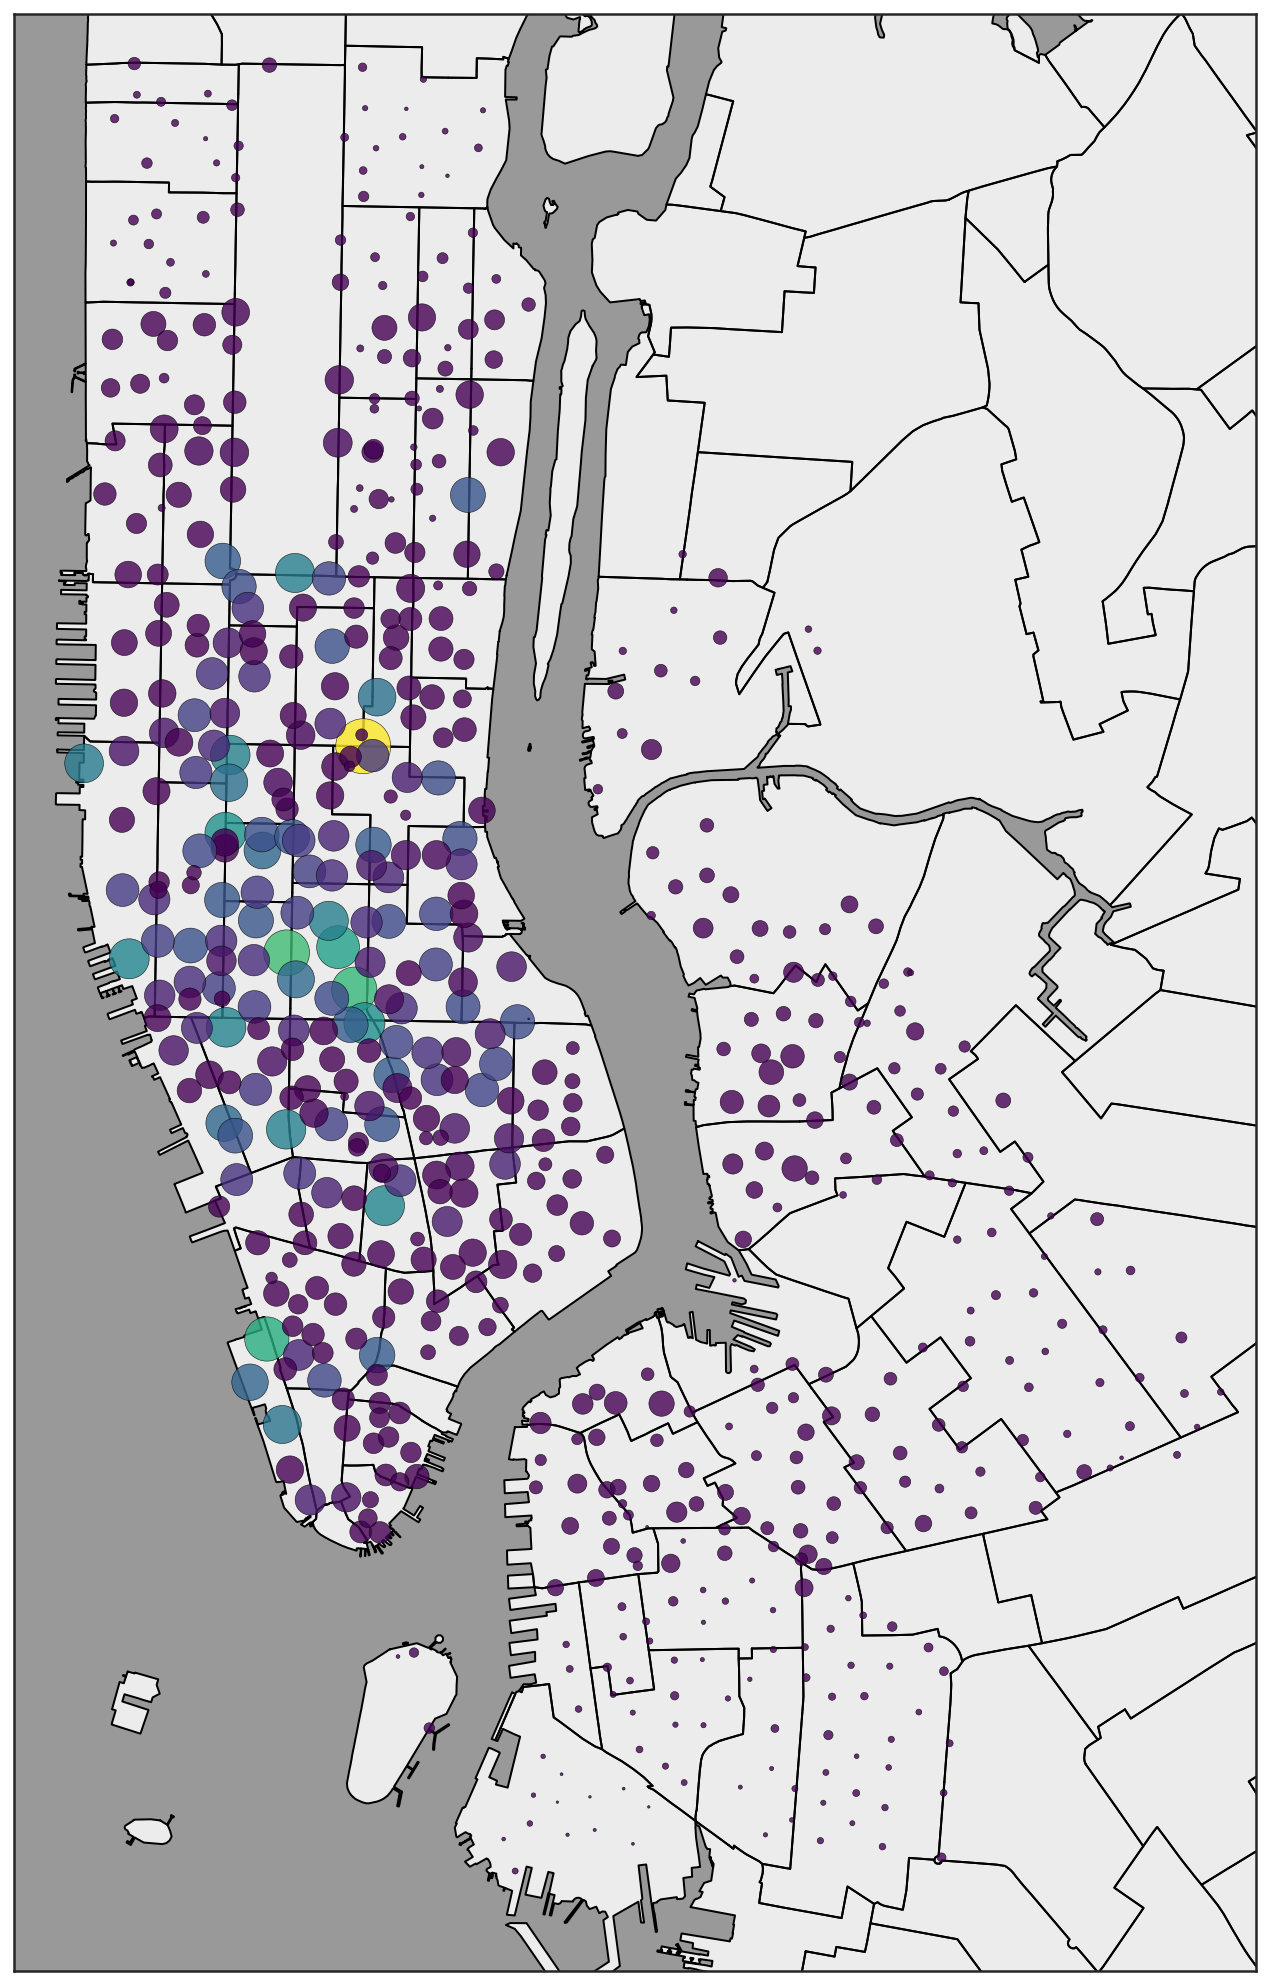

In [22]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)
plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)

ax = plt.gca()
ax.set_facecolor("#999999")

xlocs, ylocs = np.array([np.array(xy) for xy in stations.geometry.values]).T

z = ax.scatter(xlocs, ylocs, marker='o', c=stations.SQRT_N_depart, 
                      s=stations.N_depart/(N_THRESHOLD/2), cmap=plt.cm.viridis,
                      vmin=10, vmax=19, edgecolors='k', alpha=0.8, zorder=10000)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Departures after Aug 2015 shown above.

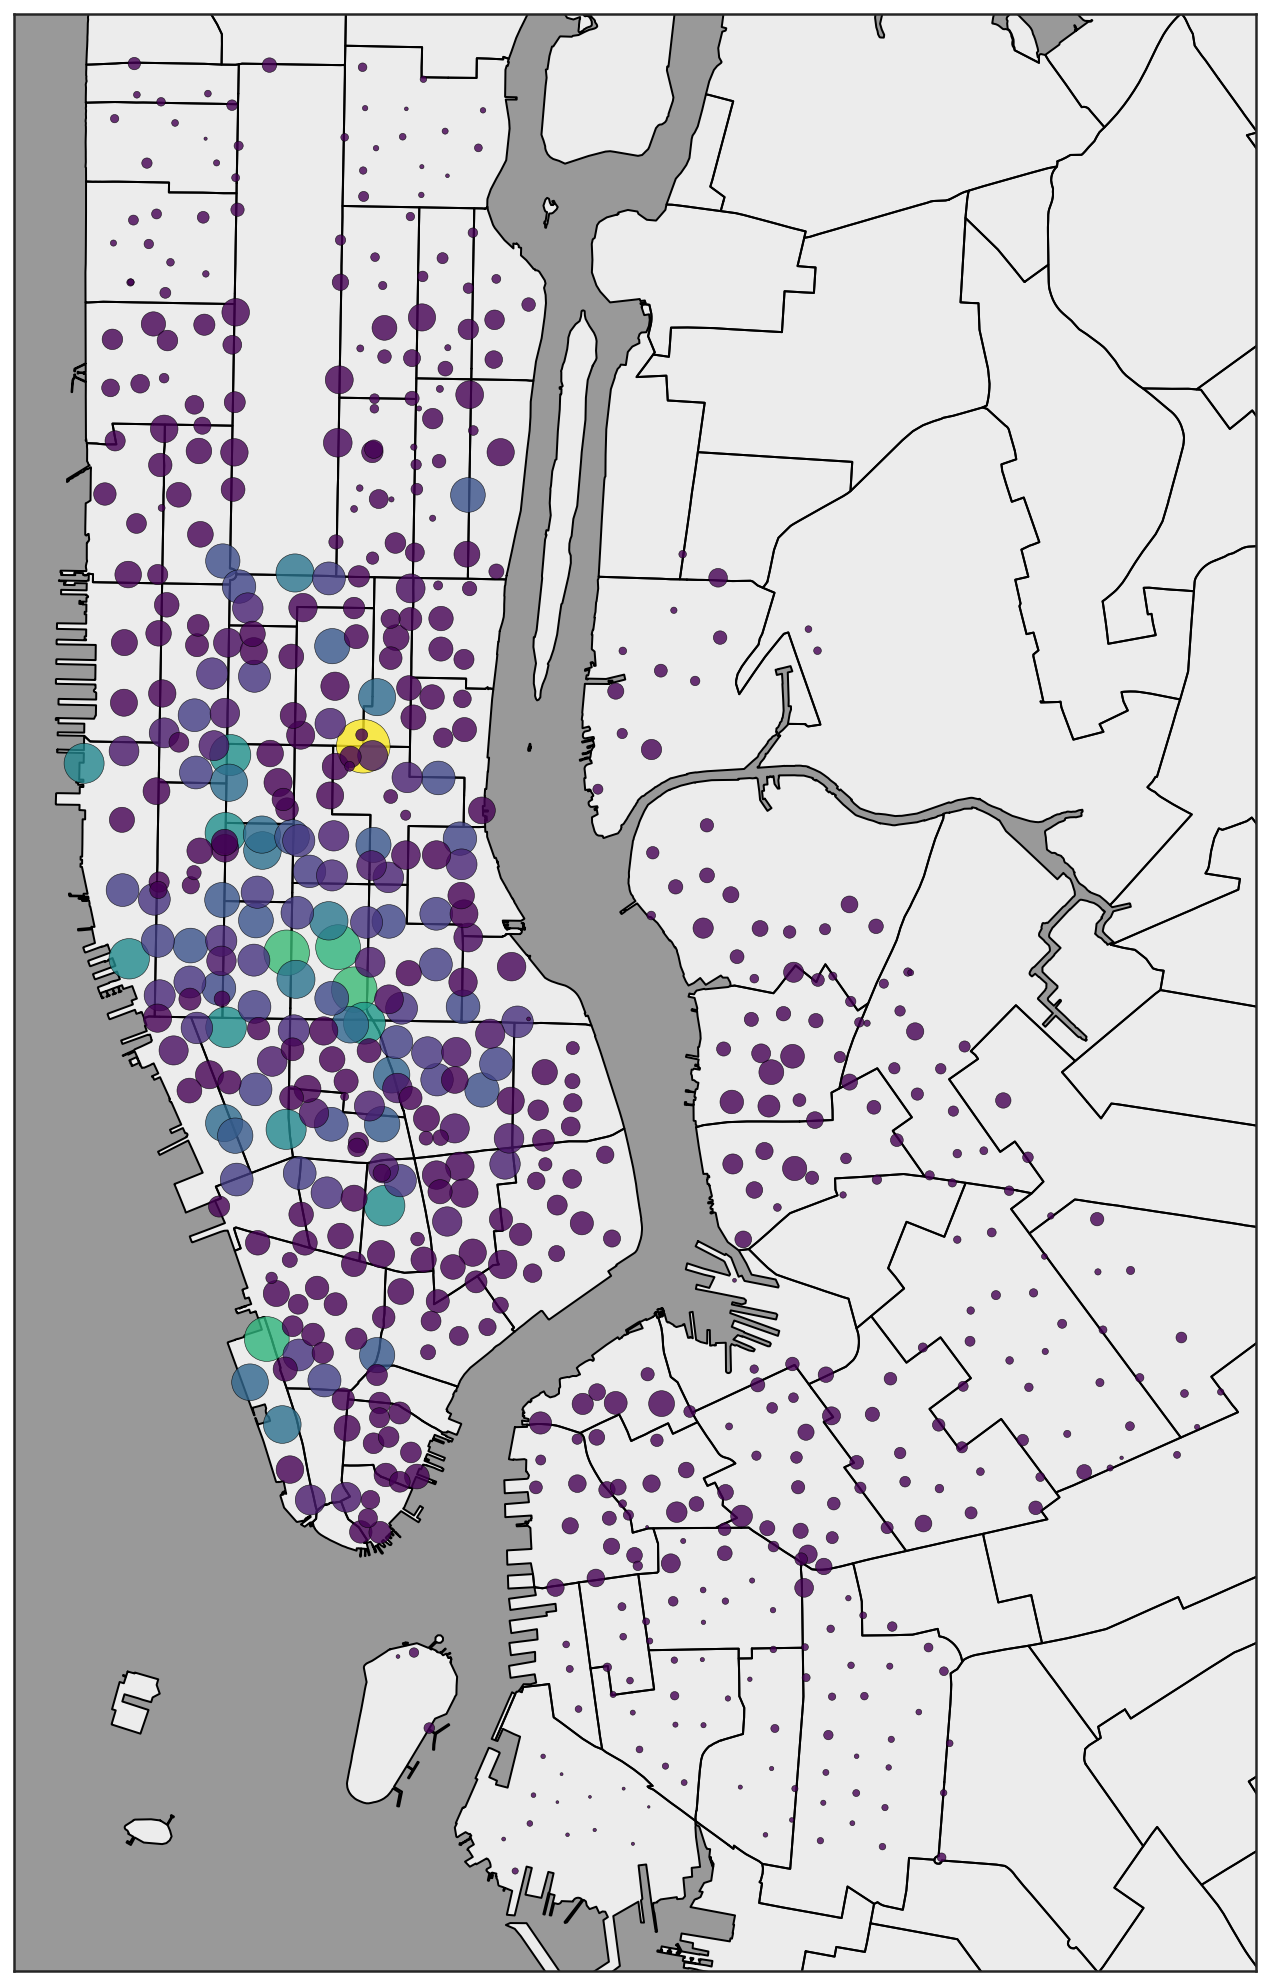

In [23]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)

plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)

ax = plt.gca()
ax.set_facecolor("#999999")

xlocs, ylocs = np.array([np.array(xy) for xy in stations.geometry.values]).T

z = plt.gca().scatter(xlocs, ylocs, marker='o', c=stations.SQRT_N_arrive, 
                      s=stations.N_arrive/(N_THRESHOLD/2), cmap=plt.cm.viridis,
                      vmin=10, vmax=19, edgecolors='k', alpha=0.8, zorder=10000)

plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

Arrivals after Aug 2015 shown above.

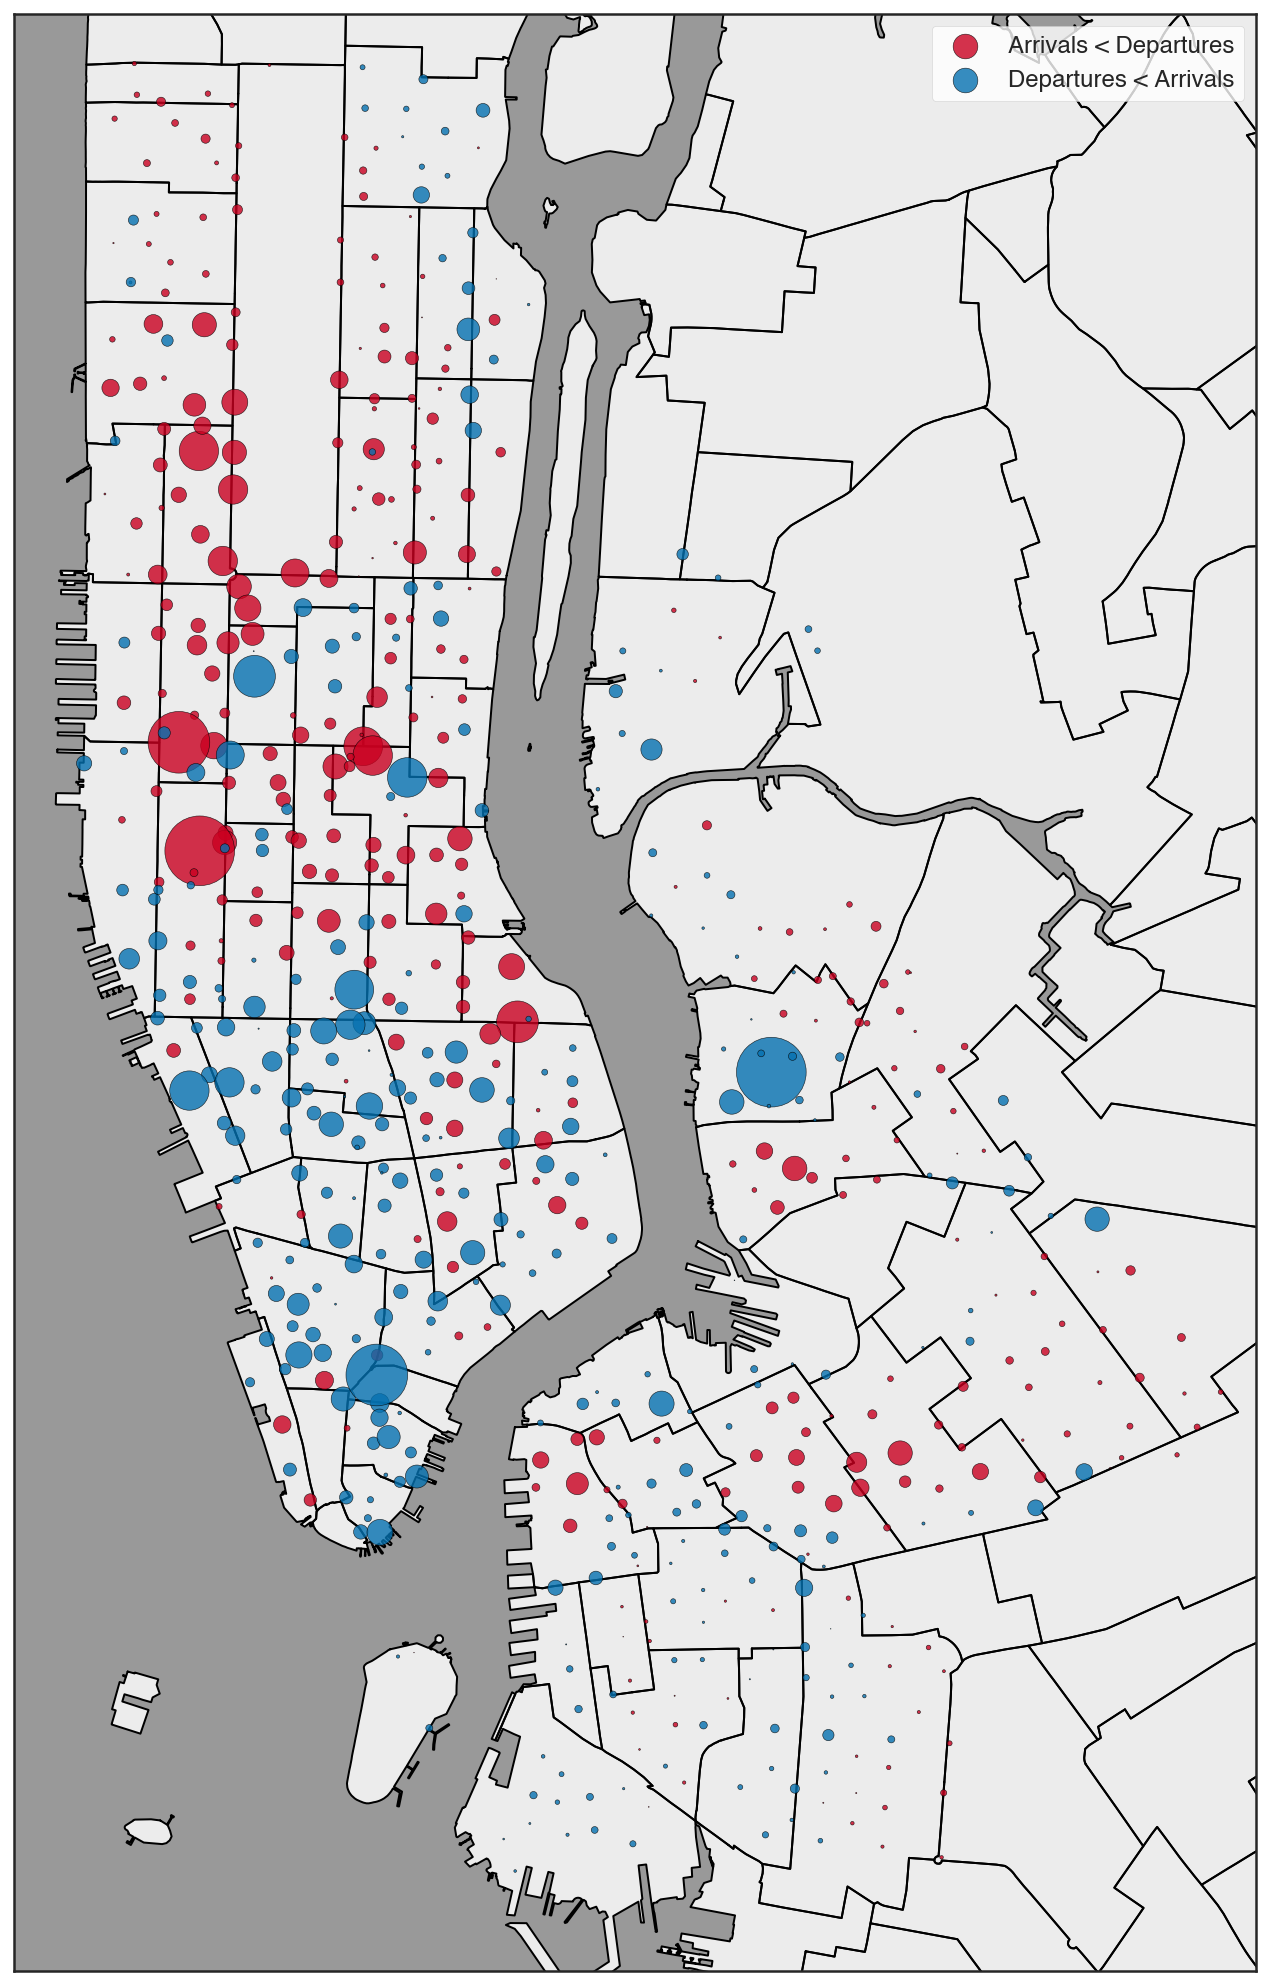

In [24]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)
plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)



ax = plt.gca()
ax.set_facecolor("#999999")

stations1 = stations[stations.N_deficit > 0]
stations2 = stations[stations.N_deficit <= 0]

xlocs, ylocs = np.array([np.array(xy) for xy in stations1.geometry.values]).T
z = plt.gca().scatter(xlocs, ylocs, marker='o', #c=stations1.N_deficit, 
                      s=stations1.N_deficit/(N_THRESHOLD/20), c=lowcolor,
                      vmin=0, vmax=4000, label='Arrivals < Departures',
                      edgecolors='k', alpha=0.8, zorder=10000)

xlocs, ylocs = np.array([np.array(xy) for xy in stations2.geometry.values]).T
z = plt.gca().scatter(xlocs, ylocs, marker='o', #c=stations1.N_deficit, 
                      s=stations1.N_deficit.abs()/(N_THRESHOLD/20), c=highcolor,
                      vmin=0, vmax=4000, label='Departures < Arrivals',
                      edgecolors='k', alpha=0.8, zorder=10000)

plt.legend(markerscale=.5, loc='upper right', frameon=True, fontsize=12)


plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

Rebalancing required after August 2015 shown above. The addition of the new stations (and possibly other changes) has significantly decreased the amount of rebalancing necessary.

# Option 3: Before August 2015

In [25]:
station_counts = spark.sql("SELECT start_station_id, count(start_station_id) as N_depart FROM bike "
                           "WHERE start_time < '2015-09-01' "
                           "GROUP BY start_station_id ORDER BY N_depart DESC") \
                     .toPandas().set_index('start_station_id', drop=True)
station_counts_2 = spark.sql("SELECT end_station_id, count(end_station_id) as N_arrive FROM bike "
                           "WHERE start_time < '2015-09-01' "
                           "GROUP BY end_station_id ORDER BY N_arrive DESC") \
        .toPandas().set_index('end_station_id', drop=True)

station_counts = station_counts.merge(station_counts_2, left_index=True, right_index=True, how='inner')
del station_counts_2

In [26]:
station_locations = spark.sql("SELECT distinct start_station_id, start_station_latitude, start_station_longitude "
          "FROM bike ORDER BY start_station_id").toPandas().groupby('start_station_id').last()
stations = station_locations.merge(station_counts, left_index=True, right_index=True)

N_THRESHOLD = 500

stations = stations[stations.N_depart + stations.N_arrive >= N_THRESHOLD]

stations = gpd.GeoDataFrame(stations,
                                     geometry=[Point(x, y) for x,y in 
                                              zip(stations.start_station_longitude, 
                                                  stations.start_station_latitude)], 
                                     crs={'init' :'epsg:4326'})
stations['SQRT_N_depart'] = (stations.N_depart ** 0.5) / (N_THRESHOLD**0.5)
stations['SQRT_N_arrive'] = (stations.N_arrive ** 0.5) / (N_THRESHOLD**0.5)
stations = stations.to_crs(tz.crs)
stations.geometry = stations.geometry.rotate(28, origin=(990000., 205000.))

In [27]:
stations['N_deficit'] = stations.N_depart - stations.N_arrive

In [28]:
stations.N_deficit.describe()

count      366.000000
mean        -0.234973
std       4100.684240
min     -15206.000000
25%      -1352.250000
50%       -140.500000
75%        437.500000
max      34725.000000
Name: N_deficit, dtype: float64

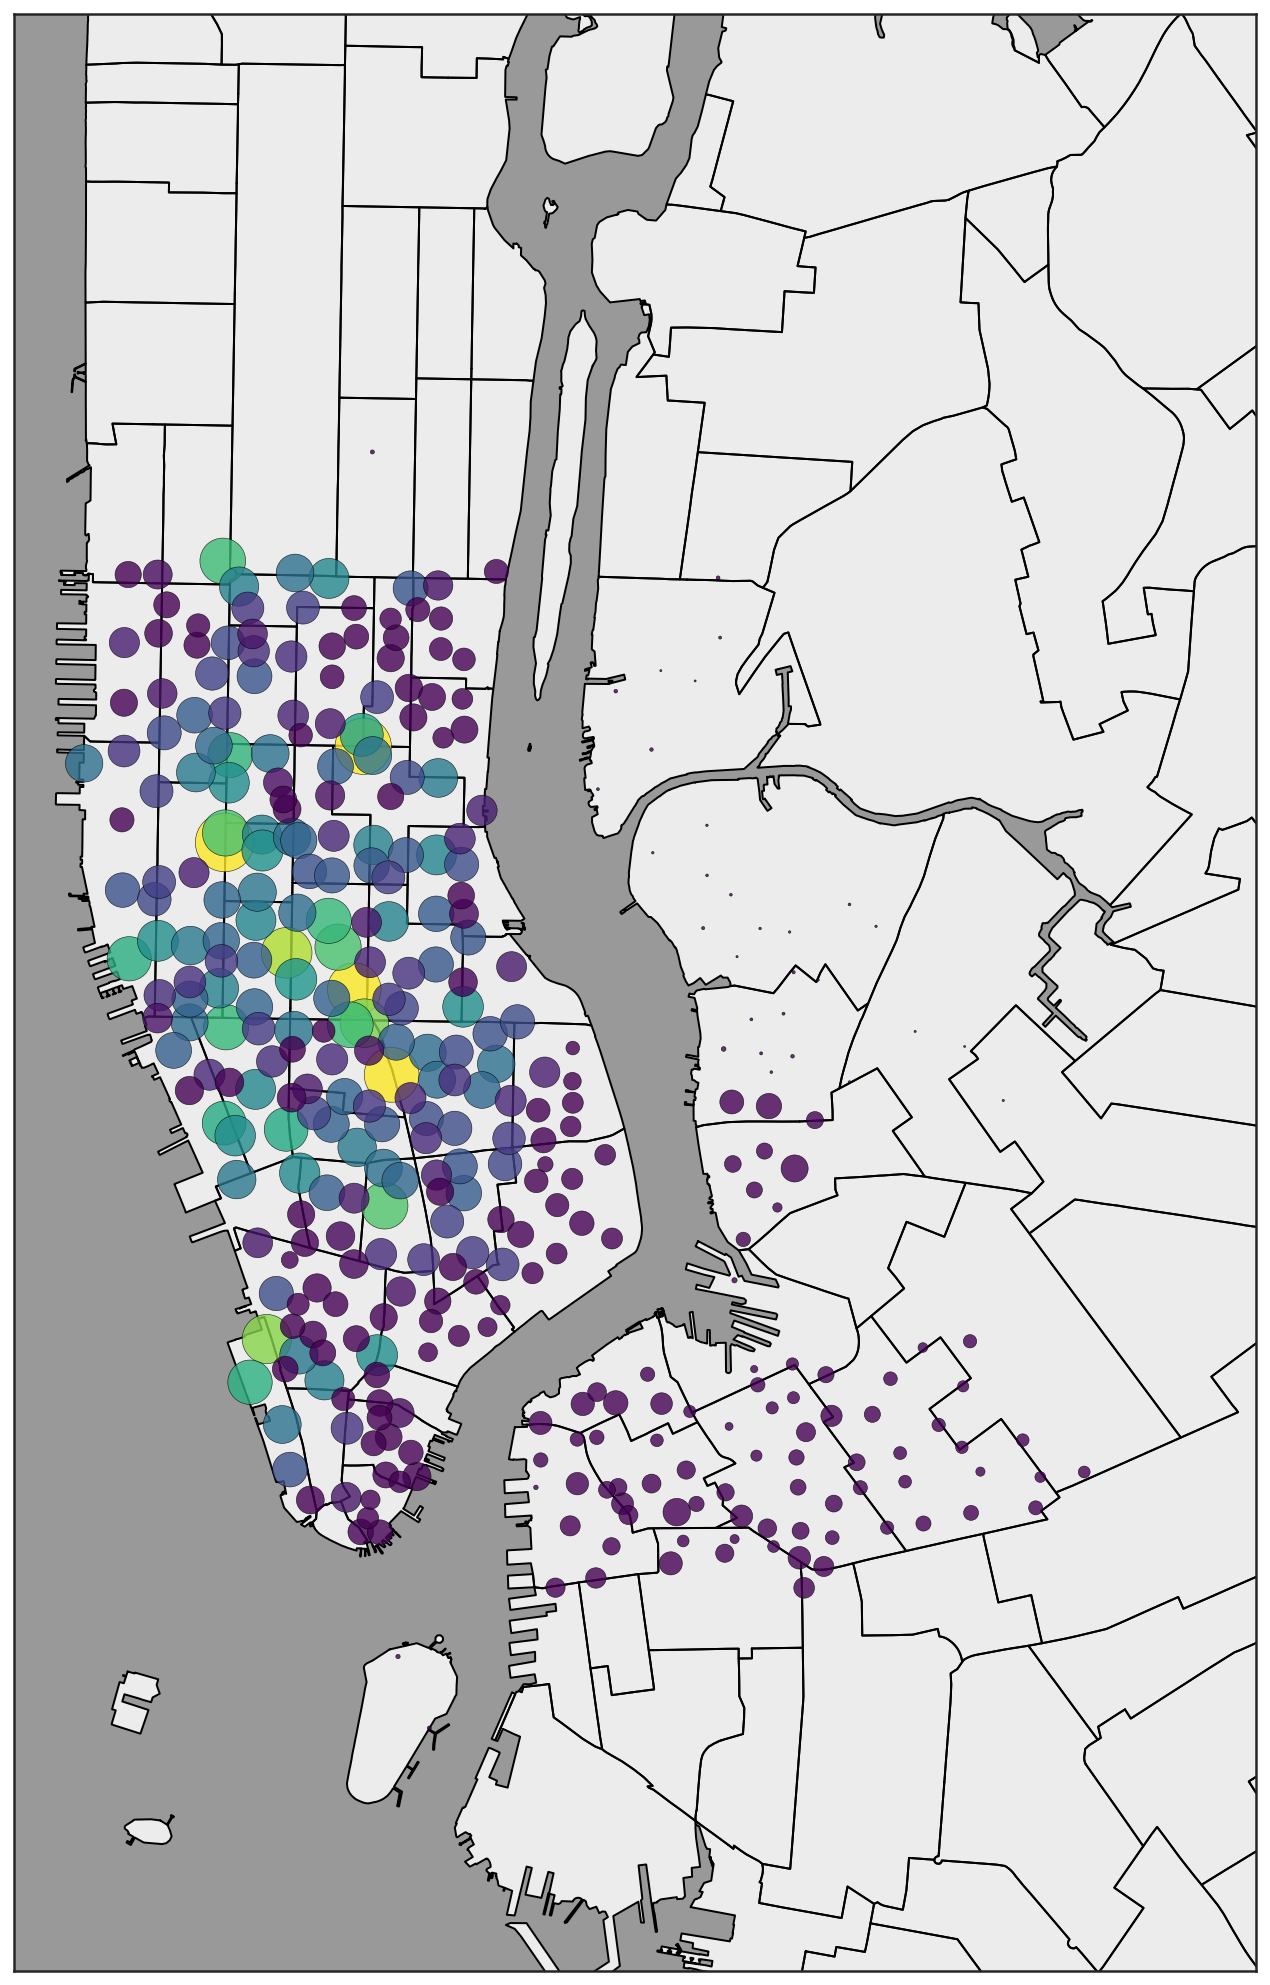

In [29]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)
plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)

ax = plt.gca()
ax.set_facecolor("#999999")

xlocs, ylocs = np.array([np.array(xy) for xy in stations.geometry.values]).T

z = ax.scatter(xlocs, ylocs, marker='o', c=stations.SQRT_N_depart, 
                      s=stations.N_depart/(N_THRESHOLD/2), cmap=plt.cm.viridis,
                      vmin=10, vmax=19, edgecolors='k', alpha=0.8, zorder=10000)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Above is departures before August 2015.

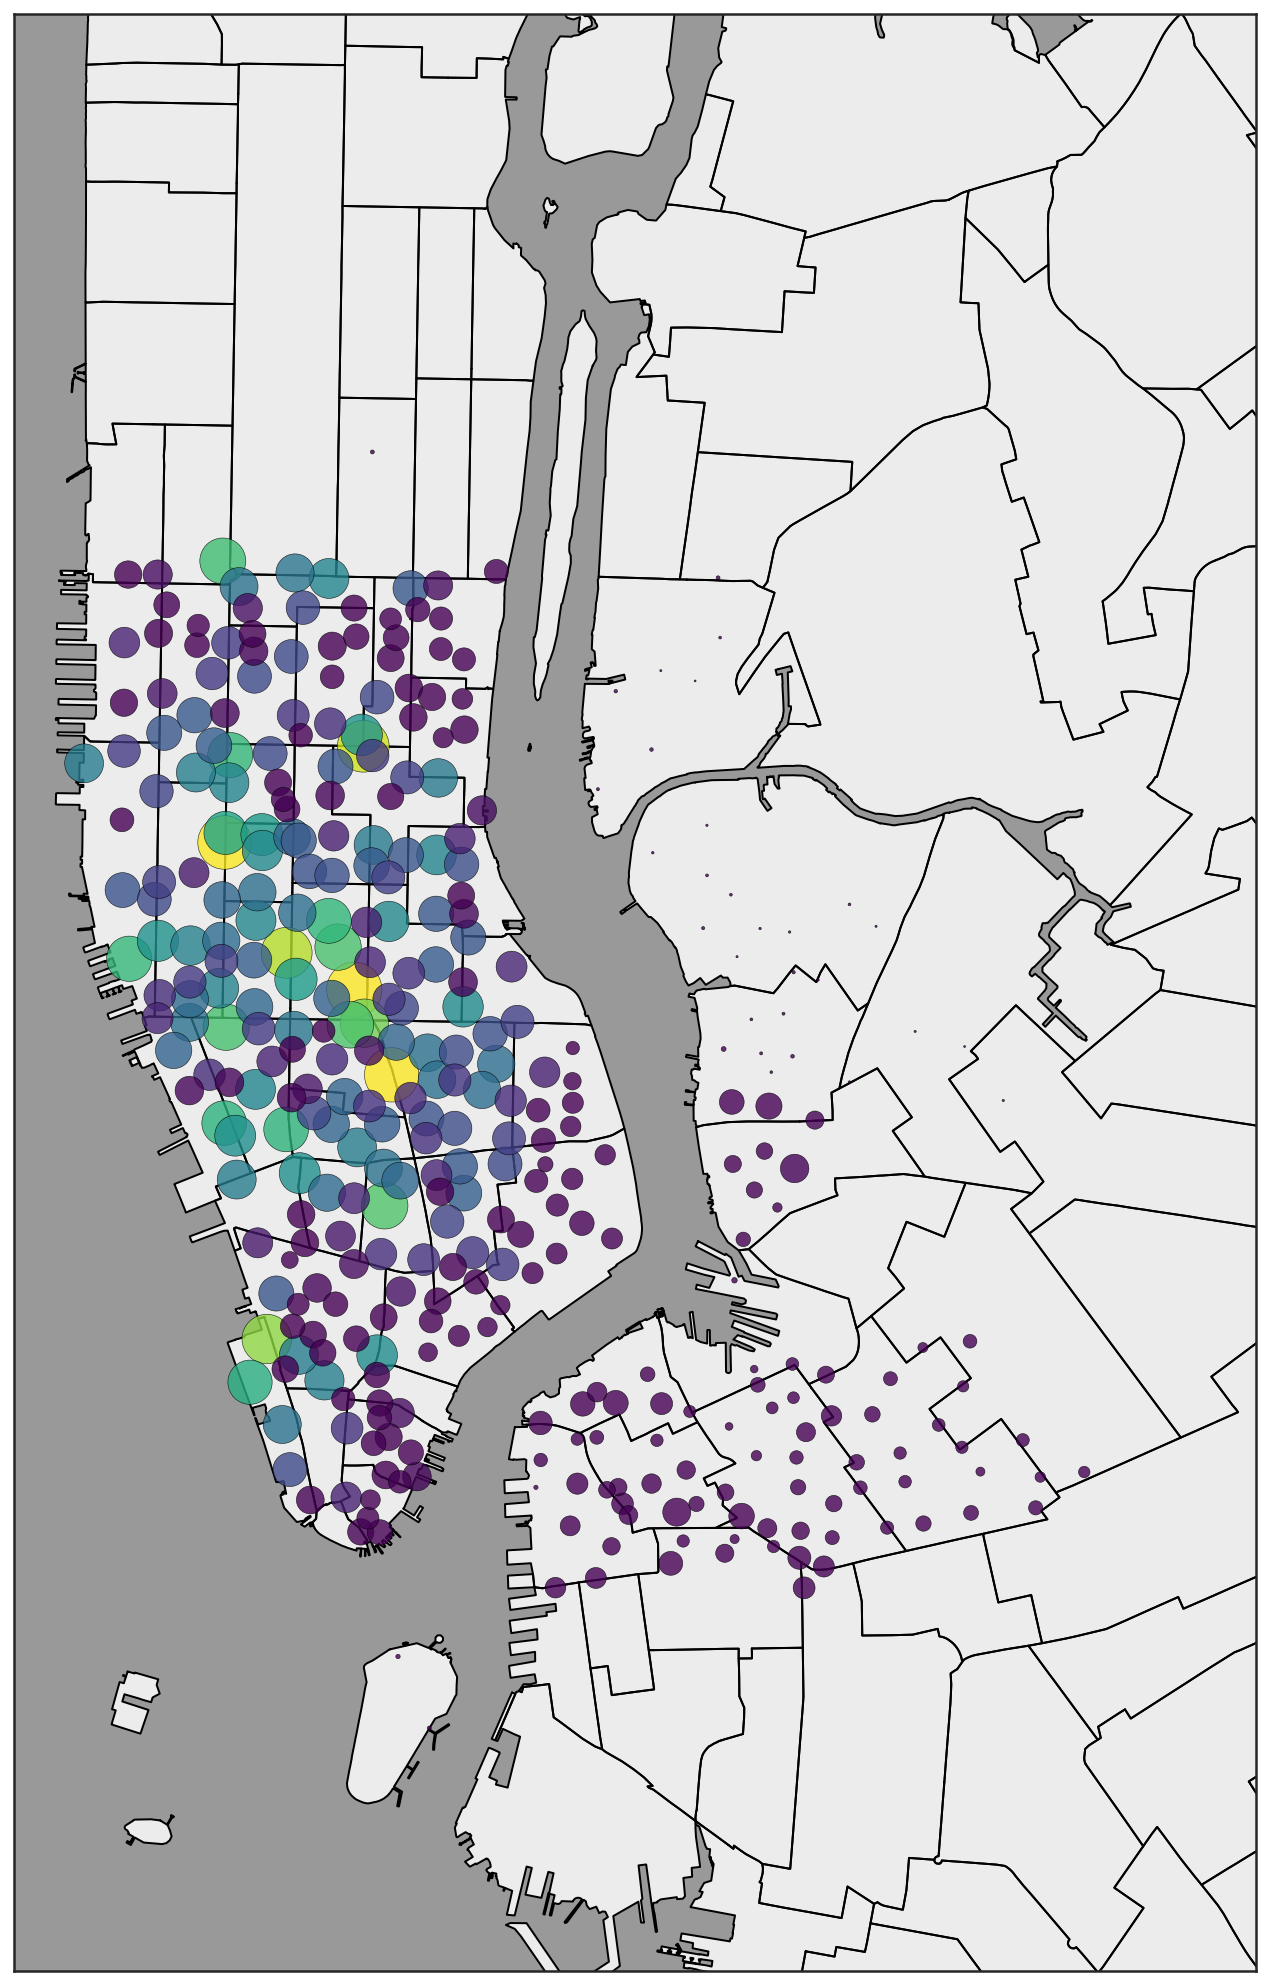

In [30]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)

plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)

ax = plt.gca()
ax.set_facecolor("#999999")

xlocs, ylocs = np.array([np.array(xy) for xy in stations.geometry.values]).T

z = plt.gca().scatter(xlocs, ylocs, marker='o', c=stations.SQRT_N_arrive, 
                      s=stations.N_arrive/(N_THRESHOLD/2), cmap=plt.cm.viridis,
                      vmin=10, vmax=19, edgecolors='k', alpha=0.8, zorder=10000)

plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

Above is arrivals after August 2015

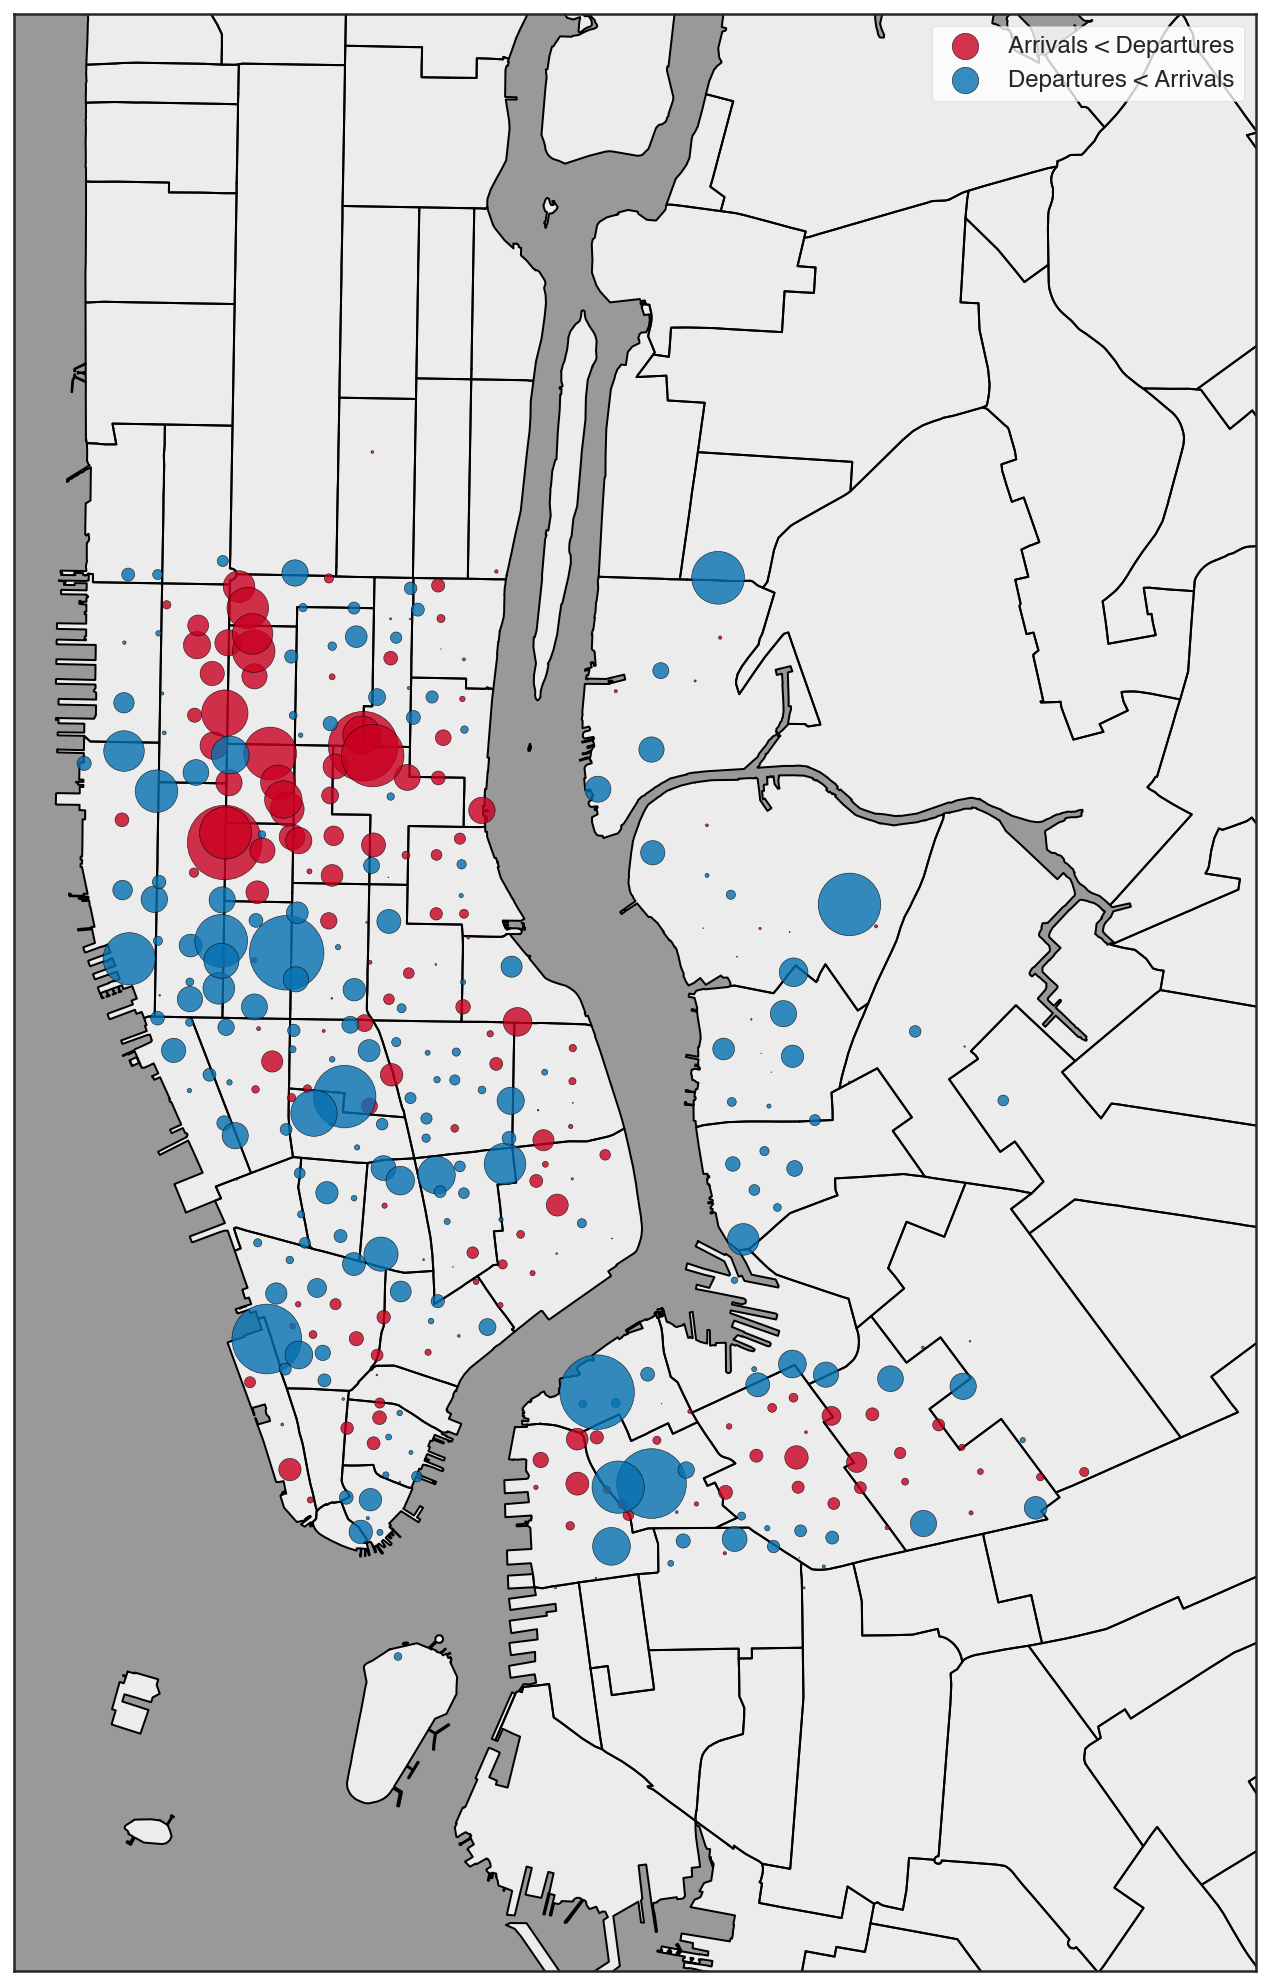

In [31]:
tz.plot(figsize=(12, 18), color='#ECECEC', alpha=1)
plt.xlim(977000, 1010000)
plt.ylim(180000, 232000)



ax = plt.gca()
ax.set_facecolor("#999999")

stations1 = stations[stations.N_deficit > 0]
stations2 = stations[stations.N_deficit <= 0]

xlocs, ylocs = np.array([np.array(xy) for xy in stations1.geometry.values]).T
z = plt.gca().scatter(xlocs, ylocs, marker='o', #c=stations1.N_deficit, 
                      s=stations1.N_deficit/(N_THRESHOLD/20), c=lowcolor,
                      vmin=0, vmax=4000, label='Arrivals < Departures',
                      edgecolors='k', alpha=0.8, zorder=10000)

xlocs, ylocs = np.array([np.array(xy) for xy in stations2.geometry.values]).T
z = plt.gca().scatter(xlocs, ylocs, marker='o', #c=stations1.N_deficit, 
                      s=stations1.N_deficit.abs()/(N_THRESHOLD/20), c=highcolor,
                      vmin=0, vmax=4000, label='Departures < Arrivals',
                      edgecolors='k', alpha=0.8, zorder=10000)

plt.legend(markerscale=.5, loc='upper right', frameon=True, fontsize=12)


plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

A lot more rebalancing was necessary before August 2015